In [485]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import random

import itertools
import re

from collections import Counter, defaultdict
import umap

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
import plotly.express as px

import pickle

In [ ]:
def count_entries_across_sublists(list_of_lists):
    flattened_list = [item for sublist in list_of_lists for item in sublist]
    return Counter(flattened_list)

def count_entries_with_indices(list_of_lists):
    counts_with_indices = defaultdict(list)
    for sublist_index, sublist in enumerate(list_of_lists):
        for item_index, item in enumerate(sublist):
            counts_with_indices[item].append((sublist_index, item_index))
    
    return counts_with_indices

In [490]:
model_name = "EleutherAI/pythia-1b-deduped"  # Specify Model Name
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

layer_ind = -3
layer = model.base_model.layers[layer_ind].mlp # Specify Layer to Hook

act = []
def hook_fn(module, input, output):
    act.append(output)
handle = layer.register_forward_hook(hook_fn)

def generate_until_period(input_text, temperature=0.5, max_length=50):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)

    generated_ids = input_ids
    while True:
        logits = model(generated_ids).logits[:, -1, :] / temperature
        

        probs = F.softmax(logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1).squeeze().item()
        generated_ids = torch.cat([generated_ids, torch.tensor([[next_token_id]], device=device)], dim=-1)
        next_token = tokenizer.decode(next_token_id)
        
        # Check if the token ends with sentence-ending punctuation
        if next_token[-1] in ['.', '!', '?']:
            break
        
        if generated_ids.shape[1] > max_length:
            break
    
    act.clear()
    
    # Forward pass to collect activations of generated tokens
    with torch.no_grad():
        model(generated_ids)

    activations = act.copy()
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(generated_ids.squeeze().tolist())

    return generated_text, tokens, activations

In [493]:
# Bank of inputs used to initiate sentence generation
input_text = ["Biology is", 'Biology is a part of', 'Biology uses', 'Biology tell us']

num_samp = 4000 #Number of sentences to generate
temp = 0.5 #Controls Temperature Parameter, NOT RESTRICTED TO TOP N TOKENS
gen_sens = []
gen_acts = []
gen_toks = []

for i in range(num_samp):
    rand_ind = random.randint(0, len(input_text)-1) #Randomly Sample an input from the bank
    generated_text, toks, acts = generate_until_period(input_text[rand_ind], temperature=temp)
    gen_sens.append(generated_text)
    gen_toks.append(toks)
    gen_acts.append(acts[0])
    print(generated_text)

Biology tell us that the first plant to appear is the one that we know as a grass.
Biology is a part of the humanities and the humanities is a part of biology.
Biology uses a similar approach to the one taken by the protein-coding genes and their functional orthologs.
Biology tell us that the world is a continuous process of change, and that the human body is a complex system that has evolved over time.
Biology uses a different set of terms.
Biology uses the term "evolutionary biology" (EB) to refer to the study of the origin and evolution of life on earth.
Biology is a part of the humanities, and it is a great pleasure to be able to teach it here.
Biology uses a similar mechanism, but with a different outcome.
Biology is the study of life, including the study of the living world, which includes the study of organisms and their interactions with other organisms.
Biology tell us that the first step in the development of the brain is the formation of the blood brain barrier (BBB).
Biolog

KeyboardInterrupt: 

In [494]:
token_counts = count_entries_across_sublists(gen_toks) #Count occurences of tokens
result2 = count_entries_with_indices(gen_toks) #Get indices for the appearances of each token 
keys = list(result2.keys()) 
print(token_counts)

Counter({'Ġthe': 1021, 'Ġof': 749, 'Ġa': 616, 'B': 613, 'iology': 611, '.': 597, 'Ġis': 566, 'Ġthat': 378, ',': 368, 'Ġto': 313, 'Ġand': 292, 'Ġpart': 182, 'Ġhuman': 173, 'Ġus': 166, 'Ġuses': 160, 'Ġtell': 159, 'Ġstudy': 149, 'Ġin': 140, 'ities': 102, 'Ġlife': 93, 'Ġare': 89, 'Ġ"': 88, '"': 85, 'Ġliving': 84, 'Ġterm': 81, 'Ġorganisms': 75, 'Ġcell': 73, 'Ġscience': 71, 'Ġit': 64, 'Ġwith': 53, 'Ġcells': 52, 'Ġnot': 51, 'Ġdifferent': 50, 'Ġrefer': 47, 'Ġbody': 44, 'Ġworld': 43, 'Ġspecies': 39, 'Ġwhich': 38, 'Ġfield': 37, 'Ġon': 36, 'Ġcomplex': 35, 'Ġbut': 35, 'Ġan': 34, 'Ġwe': 33, 'Ġtheir': 33, 'Ġas': 32, 'Ġsystem': 32, 'Ġhas': 32, 'Ġdescribe': 32, 'Ġall': 31, 'Ġby': 30, 'Ġfor': 30, 'Ġbiology': 29, 'Ġenvironment': 29, 'Ġorganism': 29, 'Ġinteractions': 27, '-': 25, 'Ġprocess': 25, 'Ġnumber': 25, 'Ġfrom': 25, 'Ġsimilar': 24, 'Ġits': 24, 'Ġthings': 24, 'Ġfirst': 23, 'Ġbe': 22, 'Ġbetween': 22, 'Ġ(': 20, 'Ġbrain': 20, 'Ġthis': 20, 'Ġbiological': 20, 'Ġmost': 20, 'Ġup': 20, 'Ġone': 19, 'Ġgene':

In [495]:
token_list = ['Ġthe', 'Ġof', 'Ġa', 'Ġis', 'Ġto', 'Ġand']

act_data = []
contexts = []
immediate_neighbors = []
color_labels = []

for i, token in enumerate(token_list):
    tok_acts = []
    token_context = []
    nghbrs = []
    token_indices = result2[token]
    for ind in token_indices:
        sen_ind, tok_pos = ind
        tok_acts.append(gen_acts[sen_ind][0,tok_pos,:].detach().numpy())
        token_context.append(gen_sens[sen_ind])
        if tok_pos < len(gen_toks[sen_ind])-1:
            
            print(tok_pos, len(gen_toks[sen_ind]))
            front = gen_toks[sen_ind][tok_pos-1]
            back = gen_toks[sen_ind][tok_pos+1]
            nghbrs.append((front, back))
        else:
            nghbrs.append(('front', 'back'))
    immediate_neighbors.append(nghbrs)
    temp_color = [i]*len(tok_acts)

    color_labels = color_labels + temp_color
    contexts.append(token_context)
    print(contexts)
    act_data.append(np.array(tok_acts))

all_data = np.vstack(act_data)

5 20
11 20
6 19
10 19
7 22
11 22
5 29
16 29
3 28
16 28
19 28
6 24
3 29
9 29
12 29
18 29
5 26
9 26
12 26
15 26
18 26
5 18
3 23
9 23
12 23
16 23
19 23
3 30
25 30
3 31
12 31
15 31
6 12
9 12
6 19
11 19
9 15
3 27
5 40
15 40
25 40
35 40
3 20
10 20
9 17
6 10
7 13
6 24
20 24
6 10
5 33
19 33
22 33
3 40
23 40
27 40
3 23
10 23
17 23
6 28
16 28
5 23
15 23
3 14
8 14
6 18
13 34
28 34
15 26
19 26
23 26
6 28
16 28
24 28
10 15
6 15
7 18
13 18
7 21
17 21
19 42
25 42
32 42
36 42
5 26
5 14
8 14
7 18
13 18
6 10
3 12
6 10
9 41
22 41
25 41
10 16
3 8
5 16
10 16
13 28
16 28
3 34
13 34
19 34
22 34
26 34
6 17
12 17
5 30
11 30
18 30
24 30
6 20
11 20
9 15
10 23
3 16
9 16
12 16
3 38
13 38
16 38
29 38
32 38
3 39
9 15
5 25
8 26
13 26
22 26
5 21
6 13
25 28
5 33
3 36
3 25
6 25
11 25
14 25
19 25
22 25
5 19
11 19
15 19
6 37
16 37
20 37
30 37
34 37
10 17
6 19
11 19
18 22
6 10
3 27
11 27
6 18
14 18
3 28
6 28
12 28
22 28
25 28
3 21
5 15
11 15
3 31
3 35
20 35
6 19
3 12
8 12
5 33
12 33
25 33
9 29
5 14
8 14
11 14
9 19
16 19
10

In [496]:
print(contexts)

[['Biology tell us that the first plant to appear is the one that we know as a grass.', 'Biology tell us that the first plant to appear is the one that we know as a grass.', 'Biology is a part of the humanities and the humanities is a part of biology.', 'Biology is a part of the humanities and the humanities is a part of biology.', 'Biology uses a similar approach to the one taken by the protein-coding genes and their functional orthologs.', 'Biology uses a similar approach to the one taken by the protein-coding genes and their functional orthologs.', 'Biology tell us that the world is a continuous process of change, and that the human body is a complex system that has evolved over time.', 'Biology tell us that the world is a continuous process of change, and that the human body is a complex system that has evolved over time.', 'Biology uses the term "evolutionary biology" (EB) to refer to the study of the origin and evolution of life on earth.', 'Biology uses the term "evolutionary bi

In [497]:
all_labels = []

for j in range(len(token_list)):

    for i, con in enumerate(contexts[j]):
        t1, t2 = immediate_neighbors[j][i]
        all_labels.append(token_list[j] + t1 + t2 + ': ' + con)


/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



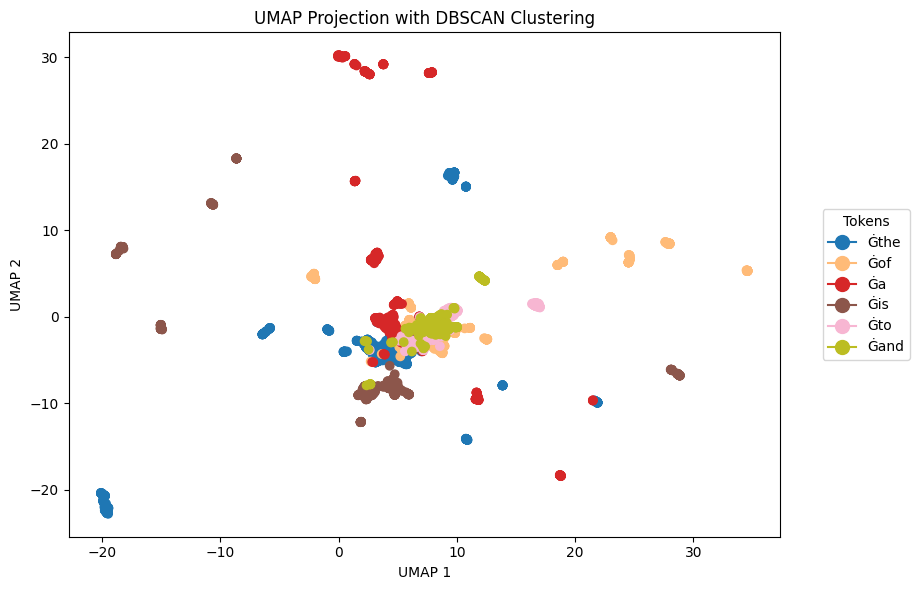

In [498]:
umap_model = umap.UMAP(n_components=2) 
X_umap = umap_model.fit_transform(all_data)

cmap = plt.get_cmap('tab20')  
norm = plt.Normalize(vmin=0, vmax=len(token_list)) 


plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=color_labels, cmap=cmap, norm=norm)
handles = []
for i in range(len(token_list)):
    color = cmap(norm(i)) 
    handle = mlines.Line2D([], [], marker='o', color=color, markerfacecolor=color, markersize=10, label=token_list[i])
    handles.append(handle)

plt.title('UMAP Projection with DBSCAN Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.legend(handles=handles, title="Tokens", bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()

In [499]:
print(len(all_labels))
print(X_umap.shape)

3557
(3557, 2)


In [500]:
fig = px.scatter(x=X_umap[:, 0], y=X_umap[:, 1])
fig.update_traces(
    hovertext=all_labels,
    hovertemplate='%{hovertext}'  # Display only the hovertext (the labels)
)
fig.show()

In [414]:
dbscan0 = DBSCAN(eps=1.0, min_samples=5)
labels0 = dbscan0.fit_predict(X_umap)
unique_labels = np.unique(labels0)

for label in unique_labels:
    print('Cluster', label)
    for j, lab in enumerate(labels0):
        if lab == label:
            print(all_labels[j])
    print('\n')

    

Cluster 0
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living organisms.
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living things.
ĠchemicalĠandĠprocesses: Biology is the study of the physical and chemical processes of living things.
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living things.
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living organisms.
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living things.
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living organisms.
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living things.
ĠchemicalĠandĠproperties: Biology is the study of the physical and chemical properties of living matter.
ĠchemicalĠandĠproperties: Biology is t

In [489]:
class ActRecord:
    
    def __init__(self, sens, toks, acts, model_name, temp, input_bank, layer) -> None:
        self.model_name = model_name
        self.layer = layer
        self.input_bank = input_bank
        self.temperature = temp
        self.sens = sens
        self.toks = toks
        self.acts = acts

save_pkl = True
file_name = 'BiologySens70mTemp25.pkl'


if save_pkl:

    to_save = ActRecord(gen_sens, gen_toks, gen_acts, model_name, temp, input_text, layer)

    with open(file_name, 'wb') as f:
        pickle.dump(to_save, f)


/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Text(0, 0.5, 'Ġorganisms Cluster Labels')

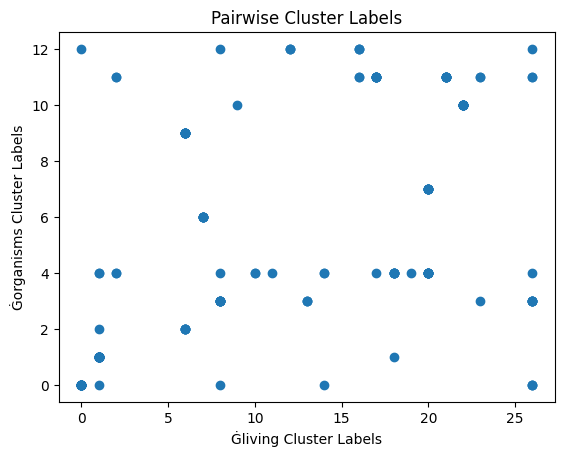

In [392]:
ind1, ind2 = 2,5

umap1 = umap.UMAP(n_components=2)
X1= umap1.fit_transform(act_data[ind1])
dbscan1 = DBSCAN(eps=1.0, min_samples=5)
labels1 = dbscan1.fit_predict(X1)

umap2 = umap.UMAP(n_components=2)
X2 = umap2.fit_transform(act_data[ind2])
dbscan2 = DBSCAN(eps=1.0, min_samples=5)
labels2 = dbscan1.fit_predict(X2)


app_tog1 = []
sh_labels = []

for r, (i, j) in enumerate(result2[token_list[ind1]]):
    for q, (k, l) in enumerate(result2[token_list[ind2]]):
        if i == k:
            sh_labels.append((labels1[r],labels2[q]))

sh_labels = np.array(sh_labels)
plt.scatter(sh_labels[:, 0], sh_labels[:, 1])
plt.title('Pairwise Cluster Labels')
plt.xlabel(token_list[ind1] + ' Cluster Labels')
plt.ylabel(token_list[ind2] + ' Cluster Labels')